In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import preproc

In [2]:
path = 'da'
train = pd.read_csv('price_train.tsv', sep='\t')
house = pd.read_csv('price_housebase.tsv', sep='\t')

In [3]:
train['month'] = pd.to_datetime(train.month)
train.head(1)

,apartment_ratio,offers_in_sites_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio
0,0.0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0


In [4]:
house['latlon'] = list(zip(house.latitude.values, house.longitude.values))

In [5]:
house.head(1)

,beauty_cnt,building_id,building_series_id,shopping_cnt,flats_count,latitude,building_type,cafe_restaurant_eating_out_cnt,unified_address,entertainment_cnt,...,site_id,healthcare_cnt,expect_demolition,longitude,ceiling_height,has_elevator,laundry_and_repair_services_cnt,build_year,city_quadkey,latlon
0,36.0,3031030817531317628,0,45.0,0,55.705219,BRICK,24.0,"Россия, Москва, 1-й Автозаводский проезд, 3",18.0,...,0,16.0,False,37.656994,0.0,True,38.0,1937,120310101302011,"(55.70521926879883, 37.6569938659668)"


In [6]:
train.head(1)

,apartment_ratio,offers_in_sites_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio
0,0.0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0


In [195]:
mask = train.groupby("city_quadkey").avg_price_sqm.\
      transform(lambda x : (x > x.mean() - x.std() * 2) & (x < x.mean() + x.std() * 2)).eq(1)

In [207]:
def kill_outlier_prices(train):
    mask = train.groupby("city_quadkey").avg_price_sqm.\
      transform(lambda x : (x > x.mean() - x.std() * 2) & (x < x.mean() + x.std() * 2)).eq(1)
    masked = pd.DataFrame({'is_ok': mask, 'city_quadkey': train.city_quadkey})
    return train.loc[mask | masked.groupby('city_quadkey').is_ok.transform(lambda x: x.sum() <= x.shape[0] / 2.)]

In [208]:
train_clear = kill_outlier_prices(train)

In [287]:
y = train.apartment_ratio
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))

for column in train.columns[1:]:
    
    y = train[column]
    mask = y.between(y.quantile(.01), y.quantile(.99))
    removed_outliers &= mask
    
    print(column, mask.size - mask.sum())

removed_outliers.value_counts()

offers_in_sites_ratio 0
unique_active_buildings_count 1475
avg_price_sqm 3295
month 0
unique_active_building_series_count 787
rooms_offered_3_ratio 0
city_quadkey 3313
median_price_sqm 3322
rooms_offered_4_more_ratio 1661
rooms_offered_1_ratio 0
total_area_avg 3131
studio_ratio 1669
offer_count 1655
rooms_offered_2_ratio 0


True     146201
False     19826
Name: apartment_ratio, dtype: int64

In [488]:
val = pd.read_csv('time.tsv', sep='\t')
val['month'] = pd.to_datetime(val.month)

In [489]:
from scipy.linalg import inv
from datetime import timedelta

def to_time(t):
    return [pd.to_datetime('2017-01-01') +
            timedelta(x) for x in t]

def regression(X, y):
    A = (X - pd.to_datetime('2017-01-01')).apply(lambda x: x.days).values
    A = np.hstack([A.reshape(-1, 1) ** 0, A.reshape(-1, 1), A.reshape(-1, 1) ** 1.3]).astype(float)
    w = inv(A.T @ A + 0.1 * np.eye(A.shape[1])) @ A.T @ y.values.reshape(-1, 1)
    
    x_reg = list(range(0, 365 * 3, 30))
    X_plt = np.array([x_reg]).reshape(-1, 1)
    X_plt = np.hstack([X_plt ** 0, X_plt, X_plt ** 1.3]).astype(float)
    
    return (X_plt, w, to_time(x_reg))

def plot_prices(cnt=5):
    numbers = np.unique(train.city_quadkey.values)
    for i in range(cnt):
        key = np.random.choice(numbers)
        
        df_clear = train_clear.groupby('city_quadkey').get_group(key)
        df = train.groupby('city_quadkey').get_group(key)
        try:
            df_val = val.groupby('city_quadkey').get_group(key)
            
            x_clear, y_clear = df_clear.month, df_clear.avg_price_sqm

            X_clear, w_clear, time = regression(x_clear, y_clear)

            x_clear = x_clear.append(df_val.month)
            y_clear = y_clear.append(df_val.avg_price_sqm)
            
            if df.shape != df_clear.shape:
                x, y = df.month, df.avg_price_sqm
                
                X, w, _ = regression(x, y)
                plt.scatter(x, y)
                plt.plot(time, X @ w)

            plt.axvline(x=pd.to_datetime('2019-08-15'), ymin=0, ymax=y.max())
            plt.scatter(x_clear, y_clear)
            plt.plot(time, X_clear @ w_clear)
        except:
            print(df.shape[0])

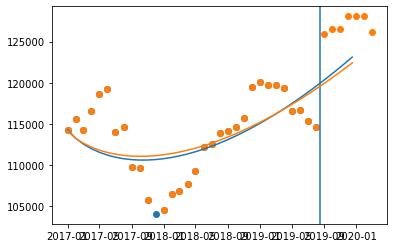

In [542]:
plot_prices(1)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

from utils import data, model, pipeline
utils = reload(utils)
utils.data = reload(utils.data)
utils.model = reload(utils.model)
utils.pipeline = reload(utils.pipeline)

from utils.data import load_data, get_all, build_ans, month_to_days
from utils.model import XGBModel
from utils.pipeline import pipeline, get_data

In [8]:
PATH = 'data/'
base = pd.read_csv(PATH + 'price_housebase.tsv', sep='\t')
train = pd.read_csv(PATH + 'price_train.tsv', sep='\t')
test = pd.read_csv(PATH + 'price_test.tsv', sep='\t')
sample = pd.read_csv(PATH + 'price_sample_submission.tsv', sep='\t')

In [9]:
train = train.sample(frac=1.).reset_index(drop=True).sort_values('month', ignore_index=True)
data = get_data(train, base, test, 0.2, path='utils/')

In [10]:
data[0][0].to_csv('data/X_train.csv', index=False)
data[1][0].to_csv('data/X_val.csv', index=False)
data[2].to_csv('data/X_test.csv', index=False)

data[0][1].to_csv('data/y_train.csv', index=False)
data[1][1].to_csv('data/y_val.csv', index=False)

In [11]:
(X_train, y_train, reg_train), (X_val, y_val, reg_val), (X_test, reg_test) = get_all(data, start_date=
                                                                                    pd.Timestamp(year=2018, month=2,
                                                                                                day=2))

C:\Users\ivan\Prog\Python\data_science\ya_kok\hackTheRealty\utils\data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['y'] = train_y


c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

# stock XGBoost

In [12]:
from utils.model import xgbmape
import xgboost

model = xgboost.XGBRegressor(n_estimators=200, max_depth=7)
model.fit(X_train.values, y_train.values, eval_set=[(X_train.values, y_train.values), 
                                                    (X_val.values, y_val.values)], eval_metric=xgbmape)

[0]	validation_0-rmse:107338.55469	validation_1-rmse:111742.15625	validation_0-mape:68.95606	validation_1-mape:70.15966
[1]	validation_0-rmse:76752.39062	validation_1-rmse:81623.53906	validation_0-mape:47.50306	validation_1-mape:49.58807
[2]	validation_0-rmse:55623.32422	validation_1-rmse:60785.92969	validation_0-mape:33.05798	validation_1-mape:35.83221
[3]	validation_0-rmse:41125.10547	validation_1-rmse:46541.84766	validation_0-mape:23.72570	validation_1-mape:27.04179
[4]	validation_0-rmse:31421.34961	validation_1-rmse:36899.18359	validation_0-mape:17.88958	validation_1-mape:21.46642
[5]	validation_0-rmse:24961.33984	validation_1-rmse:30469.47266	validation_0-mape:14.40823	validation_1-mape:17.99411
[6]	validation_0-rmse:20895.97266	validation_1-rmse:26401.28125	validation_0-mape:12.43283	validation_1-mape:15.92296
[7]	validation_0-rmse:18280.59961	validation_1-rmse:23605.50000	validation_0-mape:11.31786	validation_1-mape:14.54595
[8]	validation_0-rmse:16701.35156	validation_1-rmse:21

[70]	validation_0-rmse:10780.47266	validation_1-rmse:18876.69727	validation_0-mape:6.52767	validation_1-mape:10.52688
[71]	validation_0-rmse:10772.01660	validation_1-rmse:18879.09375	validation_0-mape:6.51505	validation_1-mape:10.52978
[72]	validation_0-rmse:10757.65430	validation_1-rmse:18878.11523	validation_0-mape:6.48304	validation_1-mape:10.52041
[73]	validation_0-rmse:10736.79199	validation_1-rmse:18867.54297	validation_0-mape:6.45937	validation_1-mape:10.51301
[74]	validation_0-rmse:10722.66309	validation_1-rmse:18856.61719	validation_0-mape:6.43764	validation_1-mape:10.50598
[75]	validation_0-rmse:10703.13965	validation_1-rmse:18854.10742	validation_0-mape:6.39921	validation_1-mape:10.47939
[76]	validation_0-rmse:10688.05957	validation_1-rmse:18851.32617	validation_0-mape:6.38665	validation_1-mape:10.46740
[77]	validation_0-rmse:10675.83691	validation_1-rmse:18853.90234	validation_0-mape:6.37057	validation_1-mape:10.46294
[78]	validation_0-rmse:10653.93945	validation_1-rmse:188

[140]	validation_0-rmse:9973.09863	validation_1-rmse:19208.20898	validation_0-mape:5.13148	validation_1-mape:9.94727
[141]	validation_0-rmse:9967.53125	validation_1-rmse:19210.21484	validation_0-mape:5.11954	validation_1-mape:9.94369
[142]	validation_0-rmse:9963.50000	validation_1-rmse:19224.28320	validation_0-mape:5.11034	validation_1-mape:9.94564
[143]	validation_0-rmse:9960.41602	validation_1-rmse:19225.28711	validation_0-mape:5.10617	validation_1-mape:9.94779
[144]	validation_0-rmse:9955.66797	validation_1-rmse:19223.27539	validation_0-mape:5.08861	validation_1-mape:9.93793
[145]	validation_0-rmse:9948.95117	validation_1-rmse:19223.36719	validation_0-mape:5.07487	validation_1-mape:9.93367
[146]	validation_0-rmse:9941.12109	validation_1-rmse:19223.48047	validation_0-mape:5.04775	validation_1-mape:9.91551
[147]	validation_0-rmse:9933.09375	validation_1-rmse:19227.82227	validation_0-mape:5.04264	validation_1-mape:9.91710
[148]	validation_0-rmse:9928.68848	validation_1-rmse:19231.40625

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
from utils.pipeline import invmape

pred_train = model.predict(X_train.values)
pred_val = model.predict(X_val.values)


print(f'Train: {invmape(y_train, pred_train)}')
print(f'Val: {invmape(y_val, pred_val)}')

Train: 95.2969619203579
Val: 90.15082081000057


# stock CatBoost

In [30]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(n_estimators=600, max_depth=10, eval_metric='MAPE')
model.fit(X_train.values, y_train.values, eval_set=[(X_train.values, y_train.values), 
                                                    (X_val.values, y_val.values)],
        early_stopping_rounds=150)

Learning rate set to 0.159587
0:	learn: 0.6508662	test: 0.6508662	test1: 0.6864256	best: 0.6864256 (0)	total: 159ms	remaining: 1m 35s
1:	learn: 0.5610100	test: 0.5610100	test1: 0.5934667	best: 0.5934667 (1)	total: 313ms	remaining: 1m 33s
2:	learn: 0.4853717	test: 0.4853717	test1: 0.5157470	best: 0.5157470 (2)	total: 474ms	remaining: 1m 34s
3:	learn: 0.4243787	test: 0.4243787	test1: 0.4537176	best: 0.4537176 (3)	total: 624ms	remaining: 1m 33s
4:	learn: 0.3728504	test: 0.3728504	test1: 0.4014563	best: 0.4014563 (4)	total: 800ms	remaining: 1m 35s
5:	learn: 0.3286039	test: 0.3286039	test1: 0.3556783	best: 0.3556783 (5)	total: 953ms	remaining: 1m 34s
6:	learn: 0.2936039	test: 0.2936039	test1: 0.3189001	best: 0.3189001 (6)	total: 1.12s	remaining: 1m 34s
7:	learn: 0.2648923	test: 0.2648923	test1: 0.2891602	best: 0.2891602 (7)	total: 1.27s	remaining: 1m 34s
8:	learn: 0.2409323	test: 0.2409323	test1: 0.2648744	best: 0.2648744 (8)	total: 1.43s	remaining: 1m 34s
9:	learn: 0.2238322	test: 0.223832

78:	learn: 0.0913586	test: 0.0913586	test1: 0.1195904	best: 0.1195904 (78)	total: 13.3s	remaining: 1m 27s
79:	learn: 0.0912047	test: 0.0912047	test1: 0.1194925	best: 0.1194925 (79)	total: 13.5s	remaining: 1m 27s
80:	learn: 0.0907970	test: 0.0907970	test1: 0.1193414	best: 0.1193414 (80)	total: 13.7s	remaining: 1m 27s
81:	learn: 0.0906032	test: 0.0906032	test1: 0.1193367	best: 0.1193367 (81)	total: 13.9s	remaining: 1m 27s
82:	learn: 0.0898949	test: 0.0898949	test1: 0.1188866	best: 0.1188866 (82)	total: 14.1s	remaining: 1m 27s
83:	learn: 0.0895421	test: 0.0895421	test1: 0.1186916	best: 0.1186916 (83)	total: 14.2s	remaining: 1m 27s
84:	learn: 0.0888615	test: 0.0888615	test1: 0.1182897	best: 0.1182897 (84)	total: 14.4s	remaining: 1m 27s
85:	learn: 0.0888565	test: 0.0888565	test1: 0.1183857	best: 0.1182897 (84)	total: 14.6s	remaining: 1m 27s
86:	learn: 0.0885936	test: 0.0885936	test1: 0.1183153	best: 0.1182897 (84)	total: 14.8s	remaining: 1m 27s
87:	learn: 0.0882196	test: 0.0882196	test1: 0.

155:	learn: 0.0688145	test: 0.0688145	test1: 0.1086267	best: 0.1086267 (155)	total: 26.9s	remaining: 1m 16s
156:	learn: 0.0688040	test: 0.0688040	test1: 0.1086490	best: 0.1086267 (155)	total: 27.1s	remaining: 1m 16s
157:	learn: 0.0684773	test: 0.0684773	test1: 0.1085376	best: 0.1085376 (157)	total: 27.3s	remaining: 1m 16s
158:	learn: 0.0682023	test: 0.0682023	test1: 0.1083780	best: 0.1083780 (158)	total: 27.4s	remaining: 1m 16s
159:	learn: 0.0680042	test: 0.0680042	test1: 0.1083581	best: 0.1083581 (159)	total: 27.6s	remaining: 1m 15s
160:	learn: 0.0678188	test: 0.0678188	test1: 0.1082230	best: 0.1082230 (160)	total: 27.8s	remaining: 1m 15s
161:	learn: 0.0677177	test: 0.0677177	test1: 0.1081030	best: 0.1081030 (161)	total: 28s	remaining: 1m 15s
162:	learn: 0.0676874	test: 0.0676874	test1: 0.1083045	best: 0.1081030 (161)	total: 28.2s	remaining: 1m 15s
163:	learn: 0.0674905	test: 0.0674905	test1: 0.1081569	best: 0.1081030 (161)	total: 28.4s	remaining: 1m 15s
164:	learn: 0.0672842	test: 0.

232:	learn: 0.0578242	test: 0.0578242	test1: 0.1031641	best: 0.1031641 (232)	total: 41.1s	remaining: 1m 4s
233:	learn: 0.0578194	test: 0.0578194	test1: 0.1031603	best: 0.1031603 (233)	total: 41.3s	remaining: 1m 4s
234:	learn: 0.0577939	test: 0.0577939	test1: 0.1031946	best: 0.1031603 (233)	total: 41.5s	remaining: 1m 4s
235:	learn: 0.0577814	test: 0.0577814	test1: 0.1032149	best: 0.1031603 (233)	total: 41.7s	remaining: 1m 4s
236:	learn: 0.0577761	test: 0.0577761	test1: 0.1032139	best: 0.1031603 (233)	total: 41.9s	remaining: 1m 4s
237:	learn: 0.0577389	test: 0.0577389	test1: 0.1032411	best: 0.1031603 (233)	total: 42.1s	remaining: 1m 4s
238:	learn: 0.0576551	test: 0.0576551	test1: 0.1031939	best: 0.1031603 (233)	total: 42.3s	remaining: 1m 3s
239:	learn: 0.0575930	test: 0.0575930	test1: 0.1032342	best: 0.1031603 (233)	total: 42.5s	remaining: 1m 3s
240:	learn: 0.0574930	test: 0.0574930	test1: 0.1032323	best: 0.1031603 (233)	total: 42.7s	remaining: 1m 3s
241:	learn: 0.0574450	test: 0.0574450

311:	learn: 0.0525393	test: 0.0525393	test1: 0.1008562	best: 0.1008317 (307)	total: 57.7s	remaining: 53.2s
312:	learn: 0.0525071	test: 0.0525071	test1: 0.1008570	best: 0.1008317 (307)	total: 57.8s	remaining: 53s
313:	learn: 0.0524704	test: 0.0524704	test1: 0.1008016	best: 0.1008016 (313)	total: 58s	remaining: 52.8s
314:	learn: 0.0524695	test: 0.0524695	test1: 0.1008030	best: 0.1008016 (313)	total: 58.1s	remaining: 52.6s
315:	learn: 0.0524526	test: 0.0524526	test1: 0.1008469	best: 0.1008016 (313)	total: 58.3s	remaining: 52.4s
316:	learn: 0.0524035	test: 0.0524035	test1: 0.1008758	best: 0.1008016 (313)	total: 58.5s	remaining: 52.2s
317:	learn: 0.0523491	test: 0.0523491	test1: 0.1008589	best: 0.1008016 (313)	total: 58.7s	remaining: 52s
318:	learn: 0.0523473	test: 0.0523473	test1: 0.1008670	best: 0.1008016 (313)	total: 58.9s	remaining: 51.8s
319:	learn: 0.0522592	test: 0.0522592	test1: 0.1008351	best: 0.1008016 (313)	total: 59.1s	remaining: 51.7s
320:	learn: 0.0522289	test: 0.0522289	test1

388:	learn: 0.0491877	test: 0.0491877	test1: 0.0996750	best: 0.0996264 (380)	total: 1m 12s	remaining: 39.5s
389:	learn: 0.0491758	test: 0.0491758	test1: 0.0996805	best: 0.0996264 (380)	total: 1m 13s	remaining: 39.3s
390:	learn: 0.0491476	test: 0.0491476	test1: 0.0996777	best: 0.0996264 (380)	total: 1m 13s	remaining: 39.1s
391:	learn: 0.0491134	test: 0.0491134	test1: 0.0996779	best: 0.0996264 (380)	total: 1m 13s	remaining: 38.9s
392:	learn: 0.0490717	test: 0.0490717	test1: 0.0996364	best: 0.0996264 (380)	total: 1m 13s	remaining: 38.7s
393:	learn: 0.0490464	test: 0.0490464	test1: 0.0996455	best: 0.0996264 (380)	total: 1m 13s	remaining: 38.5s
394:	learn: 0.0489603	test: 0.0489603	test1: 0.0996365	best: 0.0996264 (380)	total: 1m 13s	remaining: 38.4s
395:	learn: 0.0489416	test: 0.0489416	test1: 0.0996483	best: 0.0996264 (380)	total: 1m 14s	remaining: 38.2s
396:	learn: 0.0488900	test: 0.0488900	test1: 0.0996400	best: 0.0996264 (380)	total: 1m 14s	remaining: 38s
397:	learn: 0.0488540	test: 0.

466:	learn: 0.0472562	test: 0.0472562	test1: 0.0990142	best: 0.0990142 (466)	total: 1m 27s	remaining: 24.8s
467:	learn: 0.0472468	test: 0.0472468	test1: 0.0990158	best: 0.0990142 (466)	total: 1m 27s	remaining: 24.6s
468:	learn: 0.0472403	test: 0.0472403	test1: 0.0990439	best: 0.0990142 (466)	total: 1m 27s	remaining: 24.4s
469:	learn: 0.0472182	test: 0.0472182	test1: 0.0990605	best: 0.0990142 (466)	total: 1m 27s	remaining: 24.3s
470:	learn: 0.0471813	test: 0.0471813	test1: 0.0990112	best: 0.0990112 (470)	total: 1m 27s	remaining: 24.1s
471:	learn: 0.0471793	test: 0.0471793	test1: 0.0990101	best: 0.0990101 (471)	total: 1m 28s	remaining: 23.9s
472:	learn: 0.0471593	test: 0.0471593	test1: 0.0990106	best: 0.0990101 (471)	total: 1m 28s	remaining: 23.7s
473:	learn: 0.0471241	test: 0.0471241	test1: 0.0989929	best: 0.0989929 (473)	total: 1m 28s	remaining: 23.5s
474:	learn: 0.0470887	test: 0.0470887	test1: 0.0989233	best: 0.0989233 (474)	total: 1m 28s	remaining: 23.3s
475:	learn: 0.0470744	test: 

543:	learn: 0.0456833	test: 0.0456833	test1: 0.0986822	best: 0.0986426 (534)	total: 1m 42s	remaining: 10.5s
544:	learn: 0.0456749	test: 0.0456749	test1: 0.0986757	best: 0.0986426 (534)	total: 1m 42s	remaining: 10.3s
545:	learn: 0.0456626	test: 0.0456626	test1: 0.0986882	best: 0.0986426 (534)	total: 1m 42s	remaining: 10.1s
546:	learn: 0.0456316	test: 0.0456316	test1: 0.0986635	best: 0.0986426 (534)	total: 1m 42s	remaining: 9.94s
547:	learn: 0.0456064	test: 0.0456064	test1: 0.0986590	best: 0.0986426 (534)	total: 1m 42s	remaining: 9.75s
548:	learn: 0.0456057	test: 0.0456057	test1: 0.0986584	best: 0.0986426 (534)	total: 1m 42s	remaining: 9.56s
549:	learn: 0.0455966	test: 0.0455966	test1: 0.0986627	best: 0.0986426 (534)	total: 1m 43s	remaining: 9.38s
550:	learn: 0.0455860	test: 0.0455860	test1: 0.0986610	best: 0.0986426 (534)	total: 1m 43s	remaining: 9.19s
551:	learn: 0.0455706	test: 0.0455706	test1: 0.0986677	best: 0.0986426 (534)	total: 1m 43s	remaining: 9s
552:	learn: 0.0455349	test: 0.0

In [32]:
pred_train = model.predict(X_train.values)
pred_val = model.predict(X_val.values)


print(f'Train: {invmape(y_train, pred_train)}')
print(f'Val: {invmape(y_val, pred_val)}')

Train: 95.46109651462409
Val: 90.13766241913996


In [45]:
# ans1 = build_ans(data[0][0], data[0][1], 1)
ans2 = build_ans(data[0][0], data[0][1], 2)

C:\Users\ivan\Prog\Python\data_science\ya_kok\hackTheRealty\utils\data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['y'] = train_y


c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

In [47]:
dset = data[0][0][['city_quadkey', 'month']]
# dset = dset.join(ans1, on='city_quadkey')
dset = dset.join(ans2, on='city_quadkey', lsuffix='_a1', rsuffix='_a2')
dset['days'] = dset['month'].apply(month_to_days)

In [50]:
# dset['pred_1'] = dset['days'] * dset['c1_a1'] + dset['bias_a1']
dset['pred_2'] = dset['days'] * dset['c1'] + dset['days'] * dset['days'] * dset['c2'] + dset['bias']

In [51]:
dset.drop(['city_quadkey', 'month', 'cnt_months', 'days'], axis=1, inplace=True)

In [37]:
def proc2(dX, ans1, ans2):
    dset = dX[['city_quadkey', 'month']]
    dset = dset.join(ans1, on='city_quadkey')
    dset = dset.join(ans2, on='city_quadkey', lsuffix='_a1', rsuffix='_a2')
    dset['days'] = dset['month'].apply(month_to_days)
    dset['pred_1'] = dset['days'] * dset['c1_a1'] + dset['bias_a1']
    dset['pred_2'] = dset['days'] * dset['c1_a2'] + dset['days'] * dset['days'] * dset['c2'] + dset['bias_a2']
    dset.drop(['city_quadkey', 'month', 'cnt_months_a1', 'days'], axis=1, inplace=True)
    return dset

def get_all(data):
    ans1 = build_ans(data[0][0], data[0][1], 1)
    ans2 = build_ans(data[0][0], data[0][1], 2)
    X_val = proc2(data[1][0], ans1, ans2)
    X_test = proc2(data[2], ans1, ans2)
    return X_val, X_test

In [52]:
meta_val, meta_test = get_all(data)

C:\Users\ivan\Prog\Python\data_science\ya_kok\hackTheRealty\utils\data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['y'] = train_y


c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

C:\Users\ivan\Prog\Python\data_science\ya_kok\hackTheRealty\utils\data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['y'] = train_y


c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\users\ivan\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\users

In [53]:
X_train, y_train = data[0][0].drop(['month', 'city_quadkey'], axis=1).values, data[0][1].values
X_val, y_val = data[1][0].drop(['month', 'city_quadkey'], axis=1).values, data[1][1].values
X_test = data[2].drop(['month', 'city_quadkey'], axis=1).values

In [54]:
model = xgboost.XGBRegressor(n_estimators=300, max_depth=7)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), 
                                                    (X_val, y_val)], eval_metric=xgbmape)

[0]	validation_0-rmse:107447.25781	validation_1-rmse:111835.74219	validation_0-mape:68.96318	validation_1-mape:70.15205
[1]	validation_0-rmse:76864.47656	validation_1-rmse:81681.13281	validation_0-mape:47.49430	validation_1-mape:49.57610
[2]	validation_0-rmse:55717.73828	validation_1-rmse:60875.48438	validation_0-mape:33.05528	validation_1-mape:35.82824
[3]	validation_0-rmse:41293.07422	validation_1-rmse:46630.50781	validation_0-mape:23.64225	validation_1-mape:26.93656
[4]	validation_0-rmse:31537.65039	validation_1-rmse:37051.97266	validation_0-mape:17.74246	validation_1-mape:21.35960
[5]	validation_0-rmse:25114.05859	validation_1-rmse:30665.82422	validation_0-mape:14.26817	validation_1-mape:17.91031
[6]	validation_0-rmse:20981.60547	validation_1-rmse:26394.22656	validation_0-mape:12.33099	validation_1-mape:16.04705
[7]	validation_0-rmse:18455.09570	validation_1-rmse:23747.47070	validation_0-mape:11.22323	validation_1-mape:14.68381
[8]	validation_0-rmse:16950.93750	validation_1-rmse:22

[70]	validation_0-rmse:11162.58594	validation_1-rmse:18273.44141	validation_0-mape:6.74540	validation_1-mape:10.66164
[71]	validation_0-rmse:11148.37012	validation_1-rmse:18273.80664	validation_0-mape:6.73620	validation_1-mape:10.65634
[72]	validation_0-rmse:11126.72168	validation_1-rmse:18275.27734	validation_0-mape:6.69452	validation_1-mape:10.64349
[73]	validation_0-rmse:11087.97461	validation_1-rmse:18259.12695	validation_0-mape:6.62950	validation_1-mape:10.61002
[74]	validation_0-rmse:11080.00879	validation_1-rmse:18258.55469	validation_0-mape:6.61903	validation_1-mape:10.61254
[75]	validation_0-rmse:11066.93164	validation_1-rmse:18265.39648	validation_0-mape:6.60442	validation_1-mape:10.60503
[76]	validation_0-rmse:11046.12402	validation_1-rmse:18256.84961	validation_0-mape:6.56859	validation_1-mape:10.59083
[77]	validation_0-rmse:11000.04785	validation_1-rmse:18334.33398	validation_0-mape:6.56159	validation_1-mape:10.61633
[78]	validation_0-rmse:10964.35449	validation_1-rmse:183

[140]	validation_0-rmse:10252.18262	validation_1-rmse:18542.82812	validation_0-mape:5.41943	validation_1-mape:10.11707
[141]	validation_0-rmse:10246.06445	validation_1-rmse:18540.93555	validation_0-mape:5.40580	validation_1-mape:10.10343
[142]	validation_0-rmse:10242.18945	validation_1-rmse:18543.24219	validation_0-mape:5.40151	validation_1-mape:10.10487
[143]	validation_0-rmse:10235.81250	validation_1-rmse:18548.06641	validation_0-mape:5.39453	validation_1-mape:10.10694
[144]	validation_0-rmse:10232.92578	validation_1-rmse:18549.40820	validation_0-mape:5.39040	validation_1-mape:10.11112
[145]	validation_0-rmse:10230.47266	validation_1-rmse:18548.03711	validation_0-mape:5.37381	validation_1-mape:10.09027
[146]	validation_0-rmse:10220.95117	validation_1-rmse:18551.04688	validation_0-mape:5.35523	validation_1-mape:10.08748
[147]	validation_0-rmse:10214.35742	validation_1-rmse:18549.59570	validation_0-mape:5.33928	validation_1-mape:10.07359
[148]	validation_0-rmse:10208.02734	validation_1

[210]	validation_0-rmse:9916.54785	validation_1-rmse:18797.69336	validation_0-mape:4.92122	validation_1-mape:9.90632
[211]	validation_0-rmse:9915.47168	validation_1-rmse:18800.20312	validation_0-mape:4.92062	validation_1-mape:9.90644
[212]	validation_0-rmse:9911.77832	validation_1-rmse:18804.28125	validation_0-mape:4.92014	validation_1-mape:9.90689
[213]	validation_0-rmse:9902.32422	validation_1-rmse:18854.48633	validation_0-mape:4.91783	validation_1-mape:9.90672
[214]	validation_0-rmse:9894.86328	validation_1-rmse:18903.83008	validation_0-mape:4.91600	validation_1-mape:9.90789
[215]	validation_0-rmse:9892.29688	validation_1-rmse:18904.46680	validation_0-mape:4.90997	validation_1-mape:9.90648
[216]	validation_0-rmse:9889.21289	validation_1-rmse:18905.50391	validation_0-mape:4.89952	validation_1-mape:9.90377
[217]	validation_0-rmse:9886.16016	validation_1-rmse:18906.60742	validation_0-mape:4.89396	validation_1-mape:9.90162
[218]	validation_0-rmse:9880.18750	validation_1-rmse:18906.08398

[281]	validation_0-rmse:9709.79590	validation_1-rmse:19145.20508	validation_0-mape:4.65694	validation_1-mape:9.84530
[282]	validation_0-rmse:9709.13379	validation_1-rmse:19148.36914	validation_0-mape:4.65555	validation_1-mape:9.84663
[283]	validation_0-rmse:9705.39160	validation_1-rmse:19160.17578	validation_0-mape:4.64942	validation_1-mape:9.85488
[284]	validation_0-rmse:9702.52637	validation_1-rmse:19161.16992	validation_0-mape:4.64462	validation_1-mape:9.85301
[285]	validation_0-rmse:9701.21191	validation_1-rmse:19161.68945	validation_0-mape:4.64244	validation_1-mape:9.85310
[286]	validation_0-rmse:9698.83496	validation_1-rmse:19162.99219	validation_0-mape:4.63707	validation_1-mape:9.85117
[287]	validation_0-rmse:9696.96191	validation_1-rmse:19163.00977	validation_0-mape:4.63098	validation_1-mape:9.84171
[288]	validation_0-rmse:9694.95508	validation_1-rmse:19162.97070	validation_0-mape:4.62710	validation_1-mape:9.84046
[289]	validation_0-rmse:9693.22363	validation_1-rmse:19165.06836

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
meta_val['xgboost'] = model.predict(X_val)
meta_test['xgboost'] = model.predict(X_test)

from sklearn.model_selection import train_test_split
X_tune, X_ctrl, y_tune, y_ctrl = train_test_split(meta_val, y_val, test_size=0.4, shuffle=False)

In [56]:
model2 = xgboost.XGBRegressor(n_estimators=300, max_depth=5)
model2.fit(X_tune.values, y_tune, eval_set=[(X_tune.values, y_tune), 
                                                    (X_ctrl.values, y_ctrl)], eval_metric=xgbmape)

[0]	validation_0-rmse:108849.64844	validation_1-rmse:110009.06250	validation_0-mape:69.46810	validation_1-mape:69.54175
[1]	validation_0-rmse:77043.76562	validation_1-rmse:77916.72656	validation_0-mape:48.27968	validation_1-mape:48.39858
[2]	validation_0-rmse:54767.21875	validation_1-rmse:55546.33203	validation_0-mape:33.75875	validation_1-mape:33.85645
[3]	validation_0-rmse:39282.91016	validation_1-rmse:40152.14453	validation_0-mape:23.89299	validation_1-mape:24.05769
[4]	validation_0-rmse:28587.36328	validation_1-rmse:29907.00586	validation_0-mape:17.18097	validation_1-mape:17.52033
[5]	validation_0-rmse:21319.70508	validation_1-rmse:23339.05664	validation_0-mape:12.72117	validation_1-mape:13.26925
[6]	validation_0-rmse:16538.27539	validation_1-rmse:19413.85938	validation_0-mape:9.79430	validation_1-mape:10.55521
[7]	validation_0-rmse:13459.63184	validation_1-rmse:17205.53906	validation_0-mape:7.97265	validation_1-mape:8.93270
[8]	validation_0-rmse:11544.37305	validation_1-rmse:15934

[71]	validation_0-rmse:7118.15332	validation_1-rmse:13945.66016	validation_0-mape:4.83031	validation_1-mape:6.75452
[72]	validation_0-rmse:7076.13965	validation_1-rmse:13930.52734	validation_0-mape:4.81895	validation_1-mape:6.73923
[73]	validation_0-rmse:7052.18897	validation_1-rmse:13925.91211	validation_0-mape:4.79358	validation_1-mape:6.72771
[74]	validation_0-rmse:7024.15527	validation_1-rmse:13904.66406	validation_0-mape:4.77785	validation_1-mape:6.71341
[75]	validation_0-rmse:6912.15918	validation_1-rmse:13873.00000	validation_0-mape:4.74918	validation_1-mape:6.69586
[76]	validation_0-rmse:6893.21191	validation_1-rmse:13863.46777	validation_0-mape:4.73422	validation_1-mape:6.68148
[77]	validation_0-rmse:6879.38135	validation_1-rmse:13856.70215	validation_0-mape:4.72508	validation_1-mape:6.67672
[78]	validation_0-rmse:6875.18652	validation_1-rmse:13855.19141	validation_0-mape:4.72134	validation_1-mape:6.67425
[79]	validation_0-rmse:6850.69189	validation_1-rmse:13847.35840	validati

[142]	validation_0-rmse:5548.36279	validation_1-rmse:13479.35742	validation_0-mape:3.98553	validation_1-mape:6.23826
[143]	validation_0-rmse:5526.24170	validation_1-rmse:13480.31250	validation_0-mape:3.96719	validation_1-mape:6.23308
[144]	validation_0-rmse:5516.45850	validation_1-rmse:13477.92773	validation_0-mape:3.95668	validation_1-mape:6.22538
[145]	validation_0-rmse:5514.40088	validation_1-rmse:13477.42383	validation_0-mape:3.94632	validation_1-mape:6.21559
[146]	validation_0-rmse:5500.51025	validation_1-rmse:13474.83203	validation_0-mape:3.93898	validation_1-mape:6.20902
[147]	validation_0-rmse:5490.67920	validation_1-rmse:13469.79492	validation_0-mape:3.92725	validation_1-mape:6.20010
[148]	validation_0-rmse:5479.38086	validation_1-rmse:13463.93066	validation_0-mape:3.91907	validation_1-mape:6.19208
[149]	validation_0-rmse:5462.67920	validation_1-rmse:13445.49316	validation_0-mape:3.91247	validation_1-mape:6.18514
[150]	validation_0-rmse:5455.52686	validation_1-rmse:13443.79102

[213]	validation_0-rmse:4838.22070	validation_1-rmse:13269.12109	validation_0-mape:3.40688	validation_1-mape:5.89845
[214]	validation_0-rmse:4832.00879	validation_1-rmse:13268.50781	validation_0-mape:3.40342	validation_1-mape:5.89779
[215]	validation_0-rmse:4830.48438	validation_1-rmse:13268.64453	validation_0-mape:3.40218	validation_1-mape:5.89761
[216]	validation_0-rmse:4821.70264	validation_1-rmse:13264.33301	validation_0-mape:3.39216	validation_1-mape:5.89138
[217]	validation_0-rmse:4816.05957	validation_1-rmse:13261.28223	validation_0-mape:3.38851	validation_1-mape:5.88840
[218]	validation_0-rmse:4811.57568	validation_1-rmse:13254.47266	validation_0-mape:3.38126	validation_1-mape:5.88147
[219]	validation_0-rmse:4782.79980	validation_1-rmse:13257.41406	validation_0-mape:3.37471	validation_1-mape:5.88487
[220]	validation_0-rmse:4775.72363	validation_1-rmse:13256.25977	validation_0-mape:3.36056	validation_1-mape:5.87838
[221]	validation_0-rmse:4770.31592	validation_1-rmse:13254.63867

[284]	validation_0-rmse:4296.17432	validation_1-rmse:13165.61914	validation_0-mape:3.01699	validation_1-mape:5.70144
[285]	validation_0-rmse:4292.78369	validation_1-rmse:13164.43066	validation_0-mape:3.01347	validation_1-mape:5.69940
[286]	validation_0-rmse:4289.26855	validation_1-rmse:13162.83106	validation_0-mape:3.00879	validation_1-mape:5.69604
[287]	validation_0-rmse:4285.73584	validation_1-rmse:13161.61231	validation_0-mape:3.00301	validation_1-mape:5.69130
[288]	validation_0-rmse:4281.37988	validation_1-rmse:13161.83789	validation_0-mape:2.99778	validation_1-mape:5.69009
[289]	validation_0-rmse:4276.98193	validation_1-rmse:13160.79883	validation_0-mape:2.99620	validation_1-mape:5.68970
[290]	validation_0-rmse:4274.44922	validation_1-rmse:13158.64551	validation_0-mape:2.99063	validation_1-mape:5.68491
[291]	validation_0-rmse:4269.94531	validation_1-rmse:13158.44336	validation_0-mape:2.97811	validation_1-mape:5.68044
[292]	validation_0-rmse:4264.39014	validation_1-rmse:13157.93262

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
sample['avg_price_sqm'] = model2.predict(meta_test.values)

In [44]:
sample.to_csv('data/tacocat.tsv', sep='\t', index=False)